# LUNA experiment: multivariate functions

In this notebook, we fit LUNA to two multivariate functions, and compare the results to NLM.

In [1]:
import sys; sys.path.insert(0, "..")
import os; imagePath = os.path.abspath('..') + '/images/'
from src.models import NLM, LUNA
from src.utils import generate_data, neg_log_likelihood, epistemic_uncertainty

In [2]:
from autograd import numpy as np
from autograd import grad
import matplotlib.pyplot as plt

## Define data generating functions

In [3]:
# data generating funnctions
def f(x, y, noise_var = 1.):
    z = 10 * np.sin( 2 * np.sqrt(x ** 2 + y ** 2))
    z_noise = z + noise_var**0.5 * np.random.normal(size=z.shape)
    return z_noise

def f2(x, y, noise_var = 1.):
    z = x**3 + y**3
    z_noise = z + noise_var**0.5 * np.random.normal(size=z.shape)
    return z_noise

def f3(x, y, noise_var = 1.):
    z = 20 * ( np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x) )
    z_noise = z + noise_var**0.5 * np.random.normal(size=z.shape)
    return z_noise


## Generate toy data from function 1



In [4]:
# Generate toy data
noise_var = 1.

# generate true contour
x1_true = np.linspace(-4, 4, 100)
x2_true = np.linspace(-4, 4, 100)

X1_true, X2_true = np.meshgrid(x1_true, x2_true)
Y_true = f(X1_true, X2_true, noise_var = 0.)

# generate x_train, y_train with a gap
x1_train = np.linspace(-3.25, 3.25, 30)
x2_train = np.linspace(-3.25, 3.25, 30)

X1, X2 = np.meshgrid(x1_train, x2_train)
gap_idx = np.logical_and(np.logical_and(X1 < 1.25, X1 > -1.25),np.logical_and(X2 < 1.25, X2 > -1.25))
Y = f(X1[~gap_idx],X2[~gap_idx], noise_var = noise_var)

x = np.stack((X1[~gap_idx].flatten(),X2[~gap_idx].flatten()))
y = Y.flatten().reshape(1,-1)
print(x.shape,y.shape)

# make a slice (with fixed value of x2 ~= 0)
x2_fixed_idx = np.argwhere(x2_train<0)[-1][0] # find the index for a value for x2 within the gap (closest to x2 ~= 0)
x2_fixed = x2_train[x2_fixed_idx] # extract the value of x2
x_train_idx = X2[~gap_idx] == x2_train[x2_fixed_idx] # identify the indices of training data on this slice
x_train_slice = X1[~gap_idx][x_train_idx] # identify the X1 values on the slice
y_train_slice = Y[x_train_idx] # identify the Y values on the slice

# generate x_test along the slice
x1_test = x1_true.copy()
x_test = np.stack((x1_test,x2_fixed*np.ones((x1_true.shape[0],))))
y_test_slice = f(x1_test,x2_fixed*np.ones((x1_true.shape[0],)), noise_var = 0.)

# generate x_test in gap and non-gap
test_gap_idx = np.logical_and(np.logical_and(X1_true < 1.25, X1_true > -1.25),np.logical_and(X2_true < 1.25, X2_true > -1.25))
test_non_gap_idx = np.logical_and(np.logical_and(np.logical_and(X1_true < 3.25, X1_true > -3.25), np.logical_and(X2_true < 3.25, X2_true > -3.25)), ~test_gap_idx)

x_test_gap = np.stack((X1_true[test_gap_idx].flatten(),X2_true[test_gap_idx].flatten()))
y_test_gap = Y_true[test_gap_idx].reshape(1,-1)

x_test_non_gap = np.stack((X1_true[test_non_gap_idx].flatten(),X2_true[test_non_gap_idx].flatten()))
y_test_non_gap = Y_true[test_non_gap_idx].reshape(1,-1)

x_test_2D = np.stack((X1_true.flatten(),X2_true.flatten()))

(2, 756) (1, 756)


## Visualize the target function

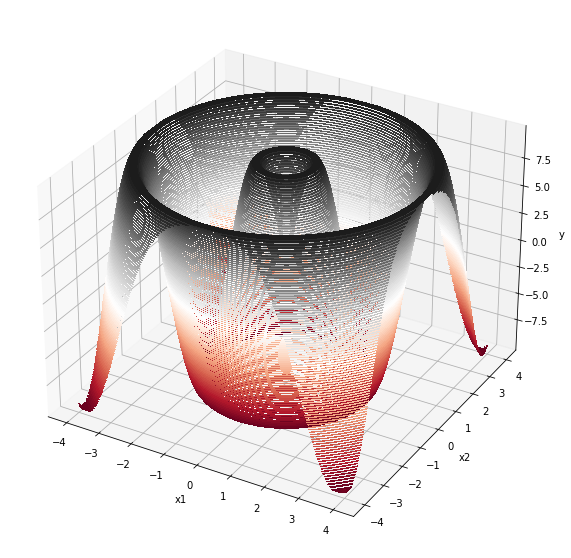

In [6]:
# Visualize ground truth of the function
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contourf(X1_true, X2_true, Y_true, 100, cmap='RdGy')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.savefig(imagePath+'2D_func-1.png',dpi=150)
plt.show()

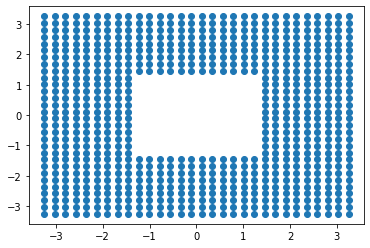

In [7]:
# plot x-y coordinate for training samples (with a gap)
plt.scatter(x[0,:],x[1,:])

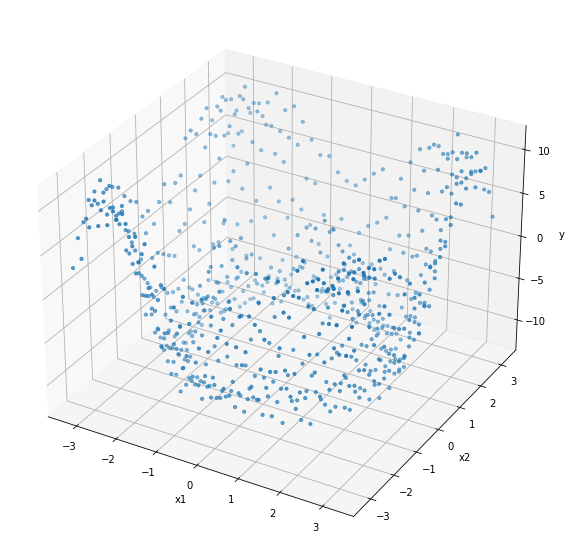

In [8]:
# Visualize training data
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x[0,:],x[1,:],y.flatten(), s = 10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

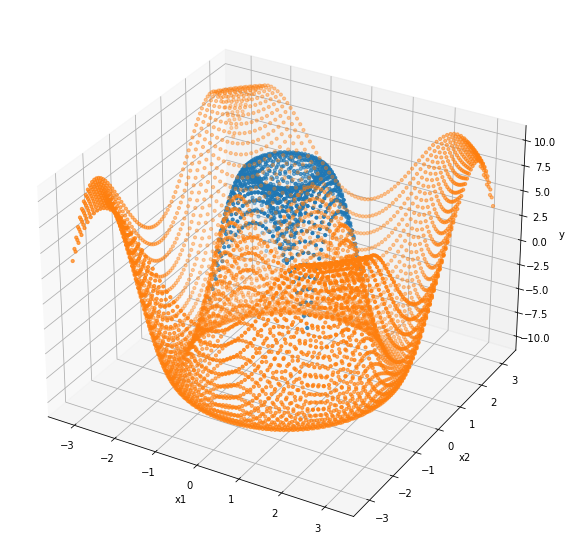

In [9]:
# Visualize test data (gap and non-gap)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x_test_gap[0,:],x_test_gap[1,:],y_test_gap.flatten(), s = 10)
ax.scatter(x_test_non_gap[0,:],x_test_non_gap[1,:],y_test_non_gap.flatten(), s = 10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()


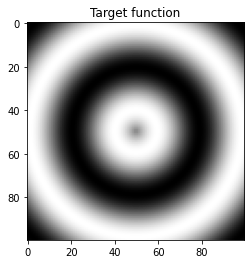

In [10]:
fig = plt.figure()
plt.imshow(Y_true, vmin = np.percentile(Y_true.flatten(),1), vmax = np.percentile(Y_true.flatten(),99), cmap='gray')
plt.title('Target function')
plt.show()

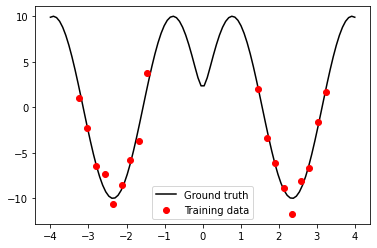

In [11]:
# visualize a slice over the 2-D function
plt.scatter(x_train_slice,y_train_slice,color='r',zorder = 100,label='Training data')
plt.plot(x_test[0,:],y_test_slice,'k',label='Ground truth')
plt.legend()
plt.show()

## Fit with LUNA

In [12]:
# relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [50,50] # using the architecture used in the paper
hidden_layers = len(width)
input_dim = 2
output_dim = 1

architecture = {
    'width': width,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
    'auxiliary_functions': 50,
}

#set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

#instantiate a NN with LUNA
luna = LUNA(architecture, random=random)
print('Number of parameters =',luna.D)

Number of parameters = 5250


### Inspect coSim^2 before fitting

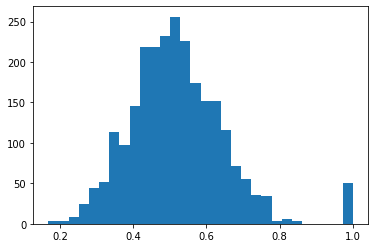

In [13]:
grad_FD = luna._finite_diff_grad(luna.weights, x) # M x dim_in x num of samples
norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints

plt.hist(coSimSqMat.flatten(),bins=30)
plt.show()

### Inspect auxiliary functions before fitting

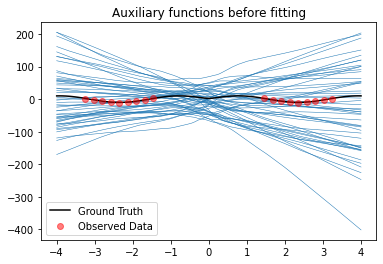

In [14]:
y_pred = luna.forward(luna.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 0.5, alpha=1, zorder = 0,color='tab:blue')
plt.title('Auxiliary functions before fitting')
plt.legend()
plt.show()

### Fit LUNA

In [15]:
### define design choices in gradient descent

params = {
    'step_size':1e-2,
    'max_iteration':2000,
    'random_restarts':1,
    'reg_param':10., # 10
    'lambda_in':10., # 10
}

# fit LUNA
luna.fit(x, y, params)

Iteration 0 loss 8044.455713103787; gradient mag: 3479.8290787186434
Iteration 100 loss 76.25589781754583; gradient mag: 21.09734352966003
Iteration 200 loss 44.78592574098653; gradient mag: 8.839121844672322
Iteration 300 loss 35.415541629209265; gradient mag: 5.398608707355867
Iteration 400 loss 31.329388622793658; gradient mag: 4.751125593209899
Iteration 500 loss 28.974374854319453; gradient mag: 3.680285661722549
Iteration 600 loss 27.22263673994746; gradient mag: 3.3026711839109746
Iteration 700 loss 25.33833840644518; gradient mag: 5.642738481346657
Iteration 800 loss 24.00083685144817; gradient mag: 5.466186209723138
Iteration 900 loss 23.064621066142326; gradient mag: 3.035072906485756
Iteration 1000 loss 22.29442079922279; gradient mag: 4.781281940187809
Iteration 1100 loss 21.751565990238127; gradient mag: 6.528865005302924
Iteration 1200 loss 21.278238265772153; gradient mag: 4.224892238128079
Iteration 1300 loss 20.854134839643905; gradient mag: 4.123935170488722
Iteration

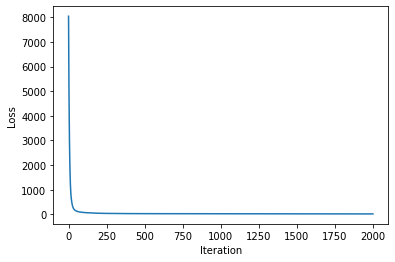

In [16]:
plt.plot(luna.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect coSim^2 after fitting

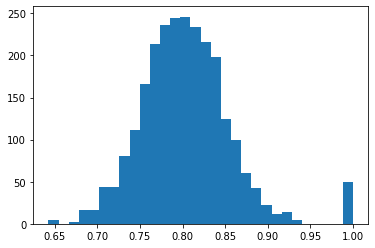

In [17]:
grad_FD = luna._finite_diff_grad(luna.weights, x) # M x dim_in x num of samples
norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints

plt.hist(coSimSqMat.flatten(),bins=30);

### Inspect auxiliary functions after fitting (along a slice)

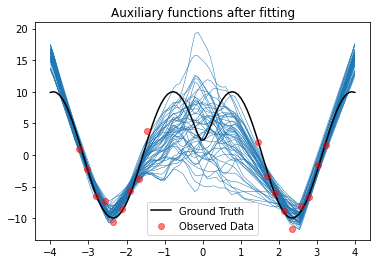

In [18]:
y_pred = luna.forward(luna.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 0.5, alpha=1, zorder = 0,color='tab:blue')
plt.title('Auxiliary functions after fitting')
plt.legend()
plt.show()

### Inspect several auxiliary functions after fitting (on all training points)

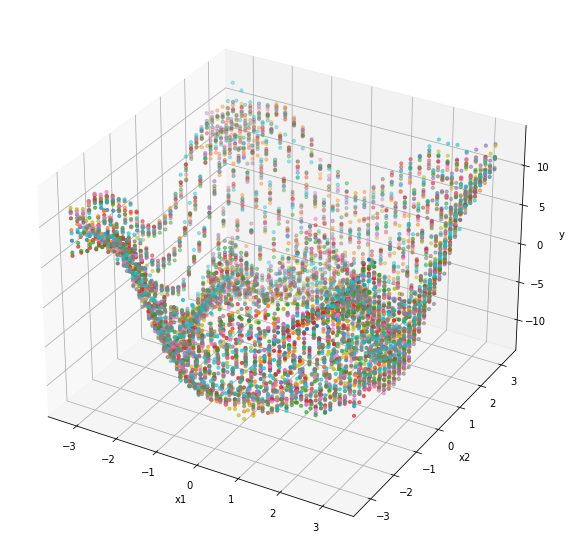

In [19]:
y_pred = luna.forward(luna.weights, x)
y_pred.shape

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

for i in range(10):    
    ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred[i,0,:], s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

### Inspect auxiliary functions after fitting on all test data

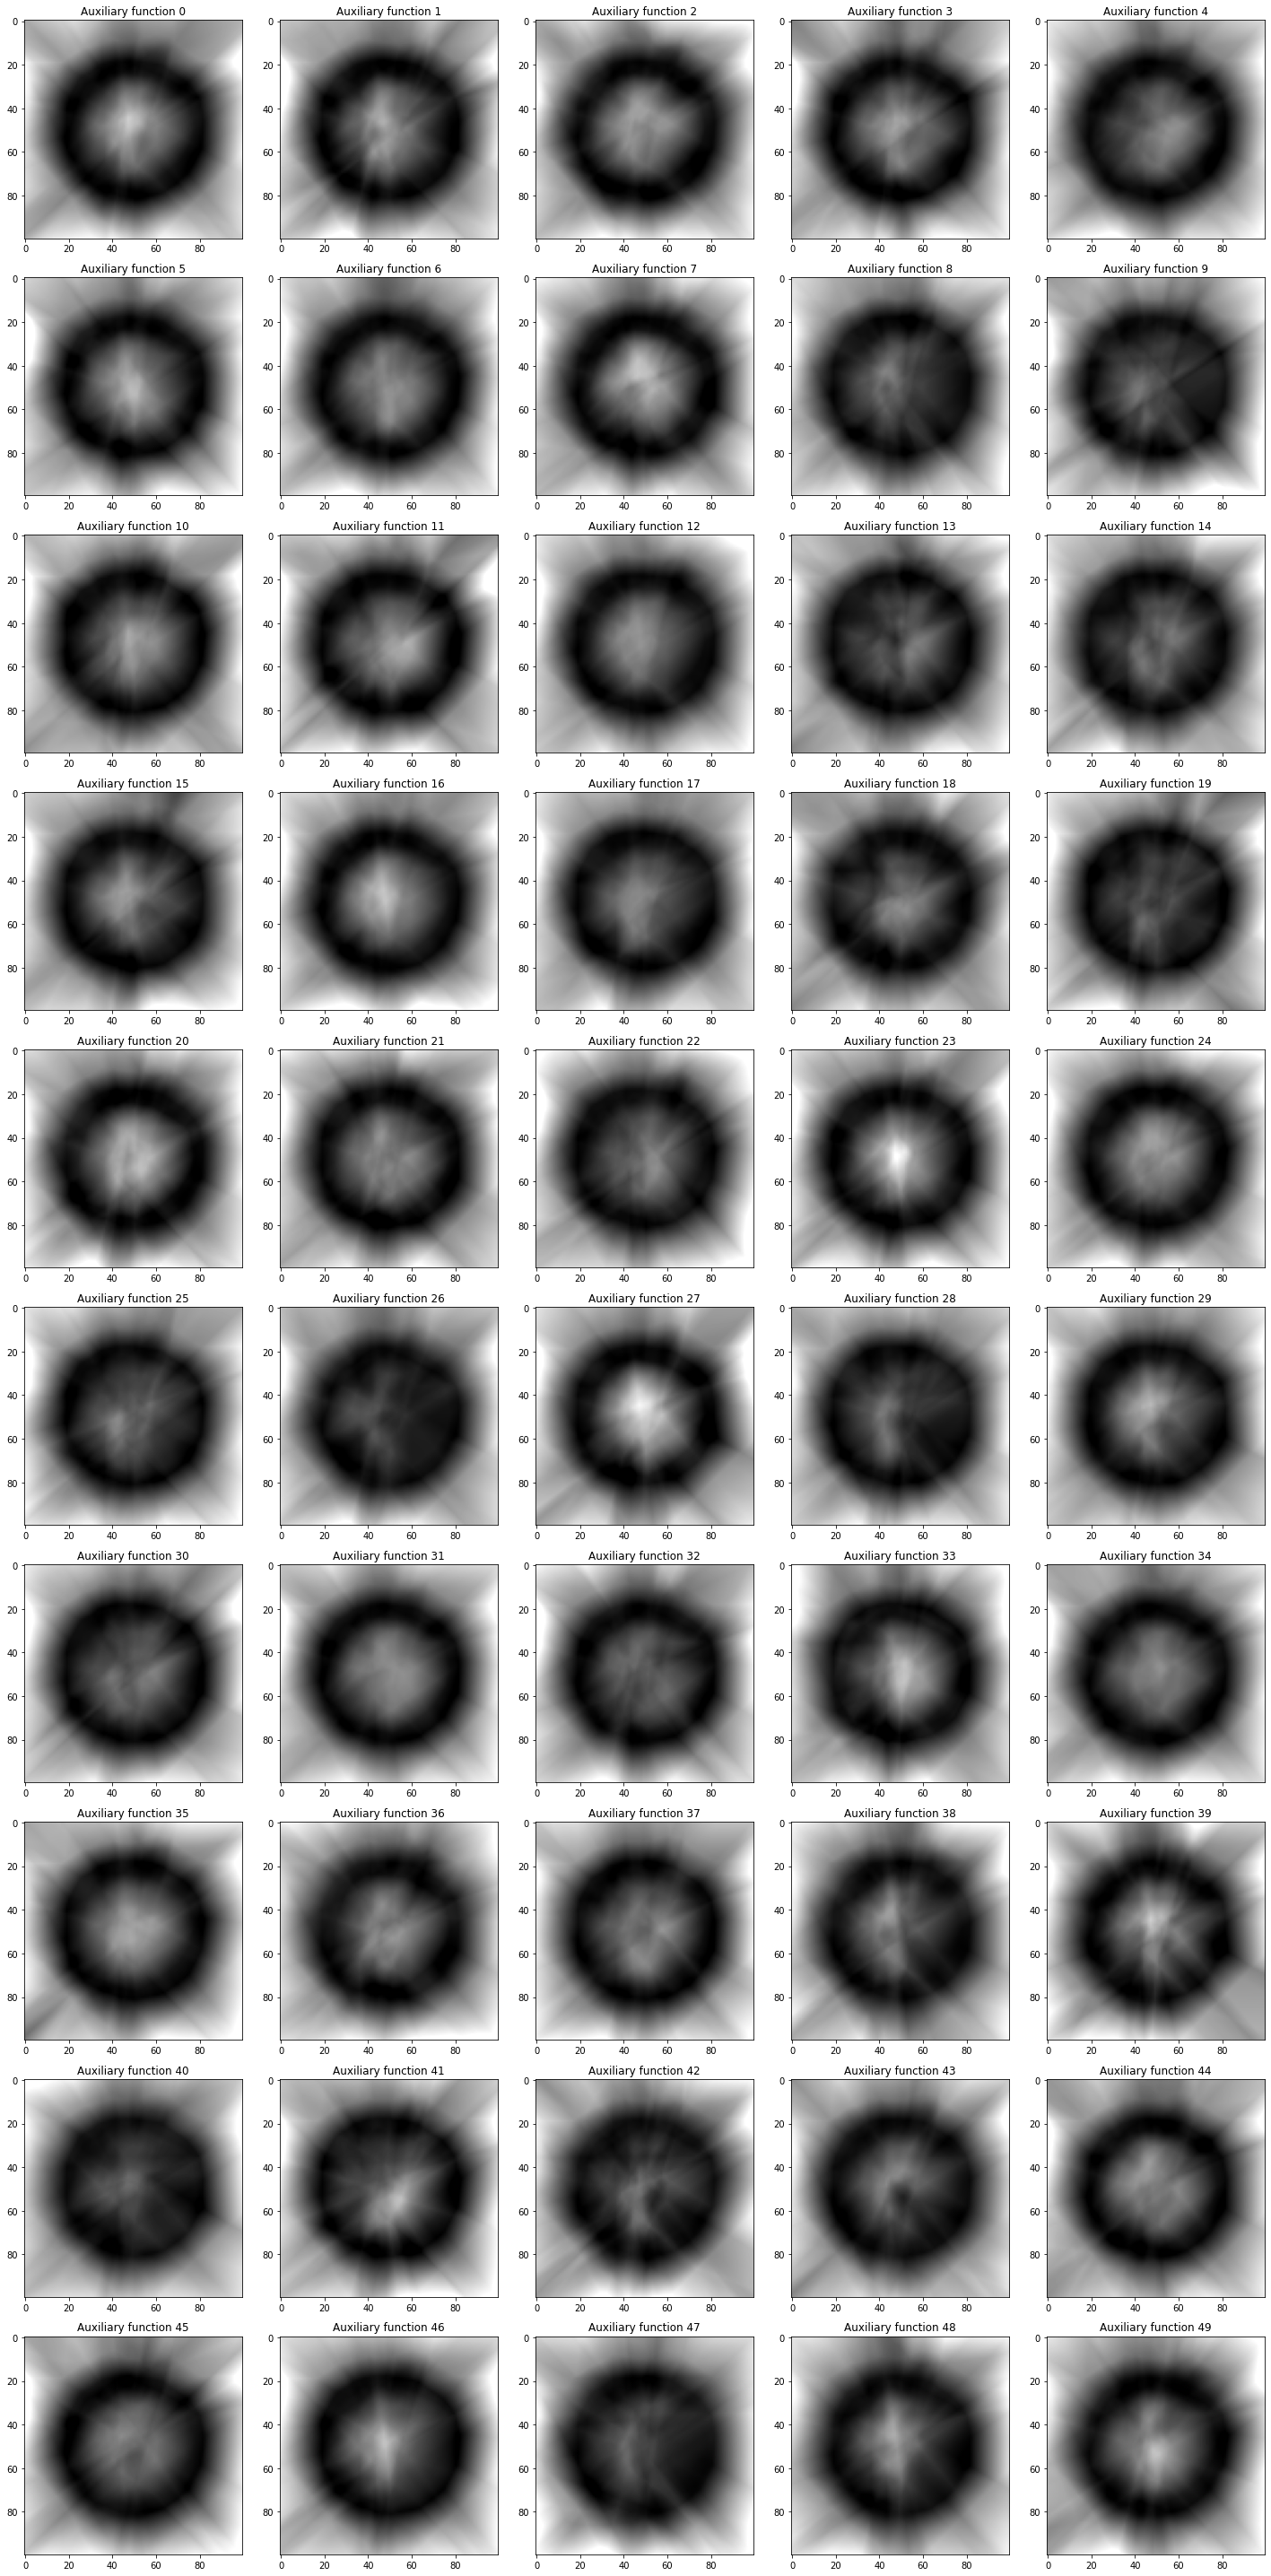

In [20]:
y_pred_test = np.squeeze(luna.forward(luna.weights, x_test_2D))

fig, axes = plt.subplots(int(np.ceil(luna.params['M']/5)), 5, figsize = (20,int(4*np.ceil(luna.params['M']/5))))
for i, ax in enumerate(axes.flat):  
    ax.imshow(y_pred_test[i,:].reshape(Y_true.shape), 
              vmin = np.percentile(y_pred_test.flatten(),1),vmax = np.percentile(y_pred_test.flatten(),99), cmap='gray')
    ax.set_title(f'Auxiliary function {i}')
plt.tight_layout()
plt.show()

### Display prior samples (along a slice)

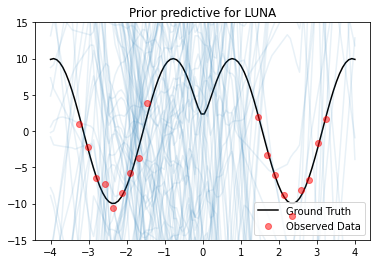

In [21]:
prior_mean = 0
prior_var = 25.
# noise_var = 9.
y_prior = luna.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-15, 15])
# plt.ylim([-150, 150])
plt.title('Prior predictive for LUNA')
plt.legend()
plt.show()

### Display posterior samples

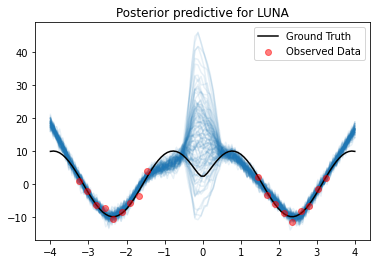

In [22]:
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, zorder = 0,color='tab:blue', alpha=0.1)
plt.title('Posterior predictive for LUNA')
plt.legend()
plt.show()

### Display posterior predictive intervals

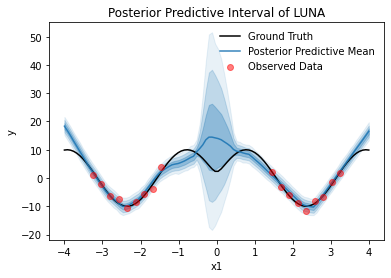

In [23]:
# Calulating percentiles
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
# plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1)
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2)
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3)
plt.legend(frameon=False)
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of LUNA")
plt.show()

### Evaluate log likelihood and epistemic uncertainty

In [24]:
# Compute neg_log_likelihood and epistemic uncertainty on training data
y_posterior = luna.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

print('Average log likelihood on training data =', -neg_log_likelihood(y_posterior, y, noise_var))
print('epistemic uncertainty on training data = ', epistemic_uncertainty(y_posterior))

Average log likelihood on training data = -2.24837698104851
epistemic uncertainty on training data =  1.0304033316613408


In [25]:
# Compute neg_log_likelihood and epistemic uncertainty on test data (gap vs. non-gap)
y_posterior_gap = luna.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_gap.shape)


y_posterior_non_gap = luna.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_non_gap.shape)


print('Average log likelihood on test data (gap) =', -neg_log_likelihood(y_posterior_gap, y_test_gap, noise_var))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(y_posterior_gap))

print('Average log likelihood on test data (non-gap) =', -neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(y_posterior_non_gap))

Average log likelihood on test data (gap) = -14.388158578247678
Epistemic uncertainty on test data (gap) =  2.4705729608854985
Average log likelihood on test data (non-gap) = -1.9119966030518762
Epistemic uncertainty on test data (non-gap) =  1.0287400778527247


### Visualize posterior mean and epistemic uncertainty on 2-D test data

In [26]:
y_posterior_test = luna.get_posterior_preds(x_test_2D, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
eps_2D = epistemic_uncertainty(y_posterior_test, take_avg=False)

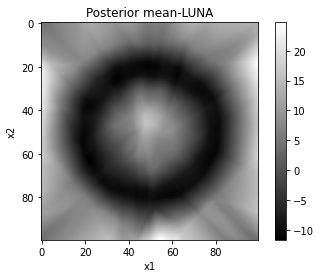

In [27]:
img = plt.imshow(y_posterior_test.mean(axis=0).reshape(Y_true.shape), cmap='gray')
plt.colorbar(img)
plt.title('Posterior mean-LUNA')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

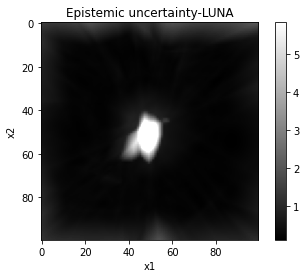

In [28]:
img = plt.imshow(eps_2D.reshape(Y_true.shape), vmax = np.percentile(eps_2D,99), cmap='gray')
plt.colorbar(img)
plt.title('Epistemic uncertainty-LUNA')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Fit with NLM for comparison (with the same hyperparameters)

In [29]:
# instantiate an NLM with same architecture 
nlm = NLM(architecture, random=random)
print('Number of parameters =', nlm.D)

# params = {
#     'step_size':1e-2,
#     'max_iteration':2000,
#     'random_restarts':1,
#     'reg_param':10.
# }

nlm.fit(x,y, params)

Number of parameters = 2751
Iteration 0 loss 2539.8004801573998; gradient mag: 7347.9316891871995
Iteration 100 loss 24.62128851152549; gradient mag: 17.472123328931964
Iteration 200 loss 19.175007672059376; gradient mag: 12.718920926613611
Iteration 300 loss 14.442820333247687; gradient mag: 6.2146637891889975
Iteration 400 loss 12.8423298087198; gradient mag: 7.630456788303659
Iteration 500 loss 11.81784356273634; gradient mag: 7.6217673889358055
Iteration 600 loss 11.043221978533957; gradient mag: 7.061869428415776
Iteration 700 loss 10.548326046137221; gradient mag: 22.22891137935467
Iteration 800 loss 10.13319818666557; gradient mag: 7.461573576681086
Iteration 900 loss 9.804180787224016; gradient mag: 10.479118555889062
Iteration 1000 loss 9.455763257856017; gradient mag: 11.032723345878928
Iteration 1100 loss 9.031726093283138; gradient mag: 30.969175009592618
Iteration 1200 loss 8.722455324729593; gradient mag: 6.006543918928509
Iteration 1300 loss 8.54914168755923; gradient ma

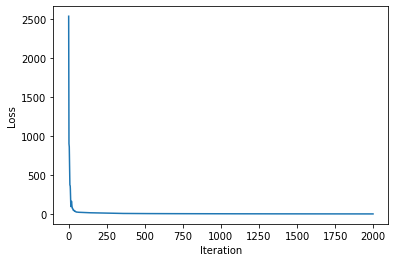

In [30]:
plt.plot(nlm.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect MLE fit

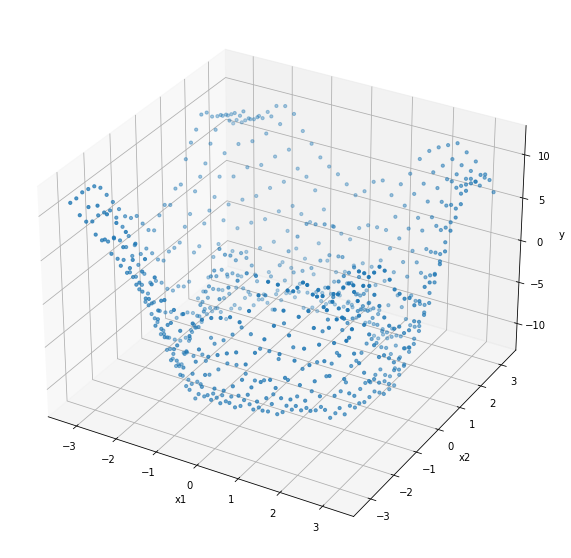

In [31]:
y_pred = nlm.forward(nlm.weights, x)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred.flatten(), s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

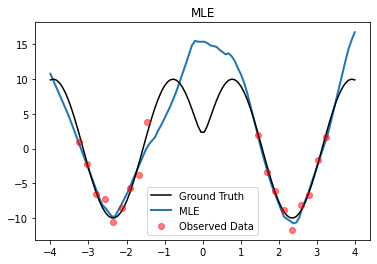

In [32]:
y_pred = nlm.forward(nlm.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 2, alpha=1, zorder = 0,color='tab:blue',label='MLE')
plt.title('MLE')
plt.legend()
plt.show()

### Display prior samples

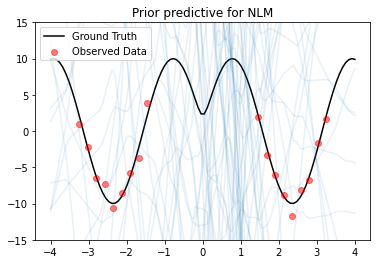

In [33]:
prior_mean = 0
prior_var = 9.
# noise_var = 9.
y_prior = nlm.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-15, 15])
# plt.ylim([-150, 150])
plt.title('Prior predictive for NLM')
plt.legend()
plt.show()

### Display posterior samples

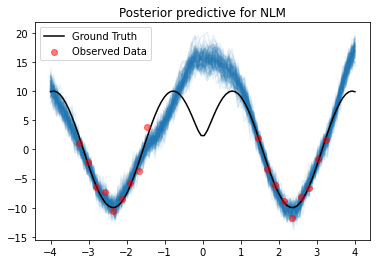

In [34]:
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape) 

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1,zorder=0)
plt.title('Posterior predictive for NLM')
plt.legend()
plt.show()

### Display posterior predictive intervals

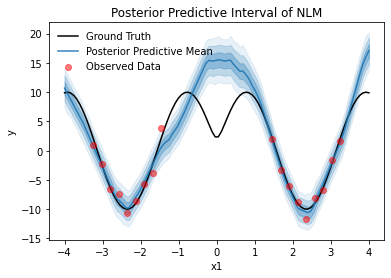

In [35]:
# Calulating percentiles
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
# plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1)
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2)
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3)
plt.legend(frameon=False)
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of NLM")
plt.show()

### Evaluate log likelihood and epistemic uncertainty

In [36]:
# Compute log likelihood and epistemic uncertainty on training data
y_posterior = nlm.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

print('Average log likelihood on training data =', -neg_log_likelihood(y_posterior, y, noise_var))
print('Epistemic uncertainty on training data = ', epistemic_uncertainty(y_posterior))

Average log likelihood on training data = -2.144168804894294
Epistemic uncertainty on training data =  1.0317891532398789


In [37]:
# Compute log likelihood and epistemic uncertainty on test data (gap vs. non-gap)
y_posterior_gap = nlm.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_gap.shape)


y_posterior_non_gap = nlm.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_non_gap.shape)


print('Average log likelihood on test data (gap) =', -neg_log_likelihood(y_posterior_gap, y_test_gap, noise_var))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(y_posterior_gap))

print('Average log likelihood on test data (non-gap) =', -neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(y_posterior_non_gap))

Average log likelihood on test data (gap) = -18.26944873732176
Epistemic uncertainty on test data (gap) =  1.1856243851480308
Average log likelihood on test data (non-gap) = -1.959219366396267
Epistemic uncertainty on test data (non-gap) =  1.0307869340264189


### Visualize posterior mean and epistemic uncertainty on 2-D test data

In [38]:
y_posterior_test = nlm.get_posterior_preds(x_test_2D, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
eps_2D = epistemic_uncertainty(y_posterior_test, take_avg=False)

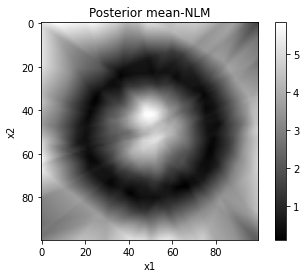

In [39]:
plt.imshow(y_posterior_test.mean(axis=0).reshape(Y_true.shape), cmap='gray')
plt.colorbar(img)
plt.title('Posterior mean-NLM')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

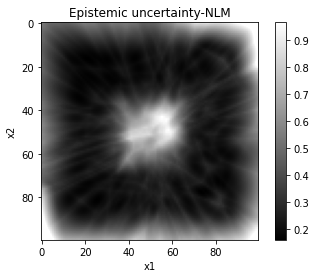

In [40]:
img = plt.imshow(eps_2D.reshape(Y_true.shape), vmax = np.percentile(eps_2D,99), cmap='gray')
plt.colorbar(img)
plt.title('Epistemic uncertainty-NLM')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

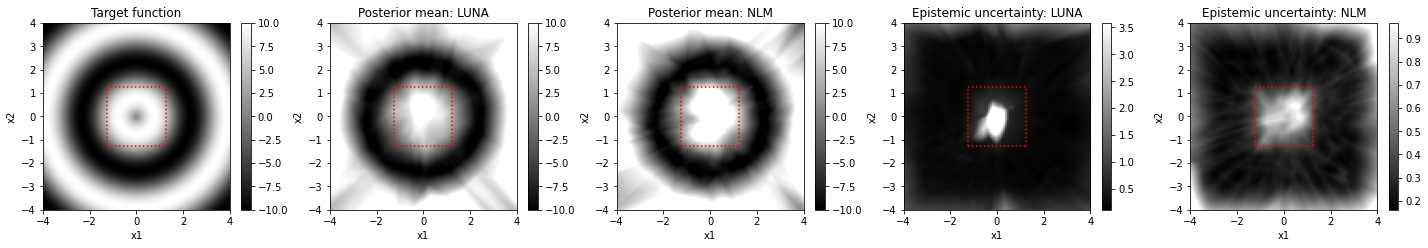

In [41]:
y_posterior_test_luna = luna.get_posterior_preds(x_test_2D, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
eps_2D_luna = epistemic_uncertainty(y_posterior_test_luna, take_avg=False)### Visualize posterior mean and epistemic uncertainty on 2-D test data
y_posterior_test_nlm = nlm.get_posterior_preds(x_test_2D, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
eps_2D_nlm = epistemic_uncertainty(y_posterior_test_nlm, take_avg=False)### Visualize posterior mean and epistemic uncertainty on 2-D test data

fig, axes = plt.subplots(1,5,figsize = (20,4))
img = axes[0].imshow(Y_true, vmax = 10, vmin = -10, cmap='gray', extent=[-4,4,-4,4])
plt.colorbar(img, ax = axes[0], shrink = 0.7)
axes[0].plot([-1.25,-1.25],[-1.25,1.25],'r:')
axes[0].plot([-1.25,1.25],[1.25,1.25],'r:')
axes[0].plot([-1.25,1.25],[-1.25,-1.25],'r:')
axes[0].plot([1.25,1.25],[-1.25,1.25],'r:')
axes[0].set(title='Target function', xlabel='x1', ylabel='x2')

img = axes[1].imshow(y_posterior_test_luna.mean(axis=0).reshape(Y_true.shape), vmax = 10, vmin = -10, cmap='gray', extent=[-4,4,-4,4])
plt.colorbar(img, ax = axes[1], shrink = 0.7)
axes[1].plot([-1.25,-1.25],[-1.25,1.25],'r:')
axes[1].plot([-1.25,1.25],[1.25,1.25],'r:')
axes[1].plot([-1.25,1.25],[-1.25,-1.25],'r:')
axes[1].plot([1.25,1.25],[-1.25,1.25],'r:')
axes[1].set(title='Posterior mean: LUNA', xlabel='x1', ylabel='x2')

img = axes[2].imshow(y_posterior_test_nlm.mean(axis=0).reshape(Y_true.shape), vmax = 10, vmin = -10, cmap='gray',extent=[-4,4,-4,4])
plt.colorbar(img, ax = axes[2], shrink = 0.7)
axes[2].plot([-1.25,-1.25],[-1.25,1.25],'r:')
axes[2].plot([-1.25,1.25],[1.25,1.25],'r:')
axes[2].plot([-1.25,1.25],[-1.25,-1.25],'r:')
axes[2].plot([1.25,1.25],[-1.25,1.25],'r:')
axes[2].set(title='Posterior mean: NLM', xlabel='x1', ylabel='x2')


img = axes[3].imshow(eps_2D_luna.reshape(Y_true.shape), vmax = np.percentile(eps_2D_luna,99), cmap='gray', extent=[-4,4,-4,4])
plt.colorbar(img, ax = axes[3], shrink = 0.7)
axes[3].plot([-1.25,-1.25],[-1.25,1.25],'r:')
axes[3].plot([-1.25,1.25],[1.25,1.25],'r:')
axes[3].plot([-1.25,1.25],[-1.25,-1.25],'r:')
axes[3].plot([1.25,1.25],[-1.25,1.25],'r:')
axes[3].set(title='Epistemic uncertainty: LUNA', xlabel='x1', ylabel='x2')

img = axes[4].imshow(eps_2D_nlm.reshape(Y_true.shape), vmax = np.percentile(eps_2D_nlm,99), cmap='gray', extent=[-4,4,-4,4])
plt.colorbar(img, ax = axes[4], shrink = 0.7)
axes[4].plot([-1.25,-1.25],[-1.25,1.25],'r:')
axes[4].plot([-1.25,1.25],[1.25,1.25],'r:')
axes[4].plot([-1.25,1.25],[-1.25,-1.25],'r:')
axes[4].plot([1.25,1.25],[-1.25,1.25],'r:')
axes[4].set(title='Epistemic uncertainty: NLM', xlabel='x1', ylabel='x2')

plt.tight_layout()
# plt.savefig(imagePath+'Comparison_2D_LUNA-1-2.png',dpi=150)
plt.show()

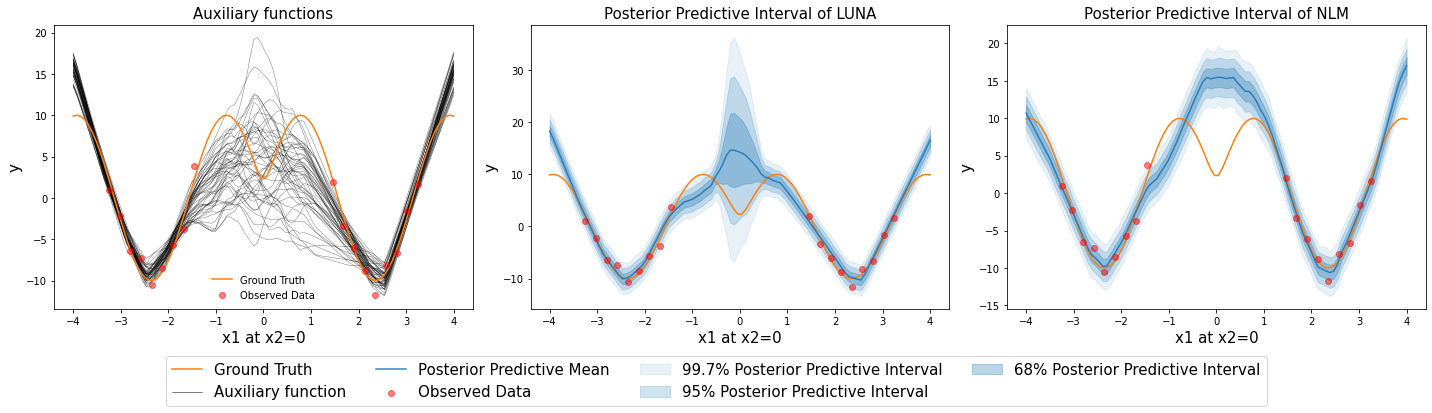

In [53]:
fig, axes = plt.subplots(1,3,figsize = (20,5))

y_pred = luna.forward(luna.weights, x_test)
axes[0].scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
axes[0].plot(x_test[0,:],y_test_slice,'tab:orange', label="Ground Truth")
axes[0].plot(x1_test.T, np.squeeze(y_pred).T,'k',linewidth = 0.5, alpha=0.5, zorder = 0)
axes[0].set_title('Auxiliary functions',fontsize = 15)
axes[0].set_xlabel('x1 at x2=0',fontsize = 15)
axes[0].set_ylabel('y',fontsize = 15)
axes[0].legend(frameon=False)


# Calulating percentiles
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing posterior predictive interval of Bayesian polynomial regression
# plt.figure(figsize=(10,7))
axes[1].scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
axes[1].plot(x_test[0,:],y_test_slice,'tab:orange', label="Ground Truth")
axes[1].plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
axes[1].fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1)
axes[1].fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2)
axes[1].fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3)

axes[1].set_xlabel('x1 at x2=0',fontsize = 15)
axes[1].set_ylabel('y',fontsize = 15)
axes[1].set_title("Posterior Predictive Interval of LUNA",fontsize = 15)


# Calulating percentiles
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
pp_mean = np.mean(y_posterior, axis=0)


# Visualizing posterior predictive interval of Bayesian polynomial regression
# plt.figure(figsize=(10,7))
axes[2].scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
axes[2].plot(x_test[0,:],y_test_slice,'tab:orange', label="Ground Truth")
axes[2].plot(np.NaN, np.NaN,'k',linewidth = 0.5, label='Auxiliary function')
axes[2].plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
axes[2].fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1, label='99.7% Posterior Predictive Interval')
axes[2].fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
axes[2].fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label='68% Posterior Predictive Interval')
axes[2].set_xlabel('x1 at x2=0',fontsize = 15)
axes[2].set_ylabel('y',fontsize = 15)
axes[2].set_title("Posterior Predictive Interval of NLM",fontsize = 15)

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4,fontsize = 15,bbox_to_anchor=(0.25, -0.16, 0.5, 0.5))

plt.tight_layout()
# plt.savefig(imagePath+'PPI_2D_LUNA-1-3.png',dpi=150, bbox_inches='tight')
plt.show()

# Repeat experiments with a different function


### Generate toy data from function 2

In [59]:
# generate toy data
noise_var = 9.

# generate true contour
x1_true = np.linspace(-5., 5., 100)
x2_true = np.linspace(-5., 5., 100)

X1_true, X2_true = np.meshgrid(x1_true, x2_true)
Y_true = f2(X1_true, X2_true, noise_var = 0.)

# generate x_train, y_train with a gap
x1_train = np.linspace(-4., 4., 30)
x2_train = np.linspace(-4., 4., 30)

X1, X2 = np.meshgrid(x1_train, x2_train)
gap_idx = np.logical_and(np.logical_and(X1 < 2., X1 > -2.), np.logical_and(X2 < 2., X2 > -2.))
# gap_idx = np.logical_and(X1 < 2., X1 > -2.)
# gap_idx = (X1**2 + X2**2)**(0.5) < 2.
Y = f2(X1[~gap_idx],X2[~gap_idx], noise_var = noise_var)

x = np.stack((X1[~gap_idx].flatten(),X2[~gap_idx].flatten()))
y = Y.flatten().reshape(1,-1)
print(x.shape,y.shape)

# make a slice (with fixed value of x2 ~= 0)
x2_fixed_idx = np.argwhere(x2_train<0)[-1][0] # find the index for a value for x2 within the gap (closest to x2 ~= 0)
x2_fixed = x2_train[x2_fixed_idx] # extract the value of x2
x_train_idx = X2[~gap_idx] == x2_train[x2_fixed_idx] # identify the indices of training data on this slice
x_train_slice = X1[~gap_idx][x_train_idx] # identify the X1 values on the slice
y_train_slice = Y[x_train_idx] # identify the Y values on the slice

# generate x_test
x1_test = x1_true.copy()
x_test = np.stack((x1_test,x2_fixed*np.ones((x1_true.shape[0],))))
y_test_slice = f2(x1_test,x2_fixed*np.ones((x1_true.shape[0],)), noise_var = 0.)

# generate x_test in gap and non-gap
test_gap_idx = np.logical_and(np.logical_and(X1_true < 1.25, X1_true > -1.25),np.logical_and(X2_true < 1.25, X2_true > -1.25))
test_non_gap_idx = np.logical_and(np.logical_and(np.logical_and(X1_true < 3.25, X1_true > -3.25), np.logical_and(X2_true < 3.25, X2_true > -3.25)), ~test_gap_idx)

x_test_gap = np.stack((X1_true[test_gap_idx].flatten(),X2_true[test_gap_idx].flatten()))
y_test_gap = Y_true[test_gap_idx].reshape(1,-1)

x_test_non_gap = np.stack((X1_true[test_non_gap_idx].flatten(),X2_true[test_non_gap_idx].flatten()))
y_test_non_gap = Y_true[test_non_gap_idx].reshape(1,-1)

x_test_2D = np.stack((X1_true.flatten(),X2_true.flatten()))

(2, 704) (1, 704)


## Visualize the target function

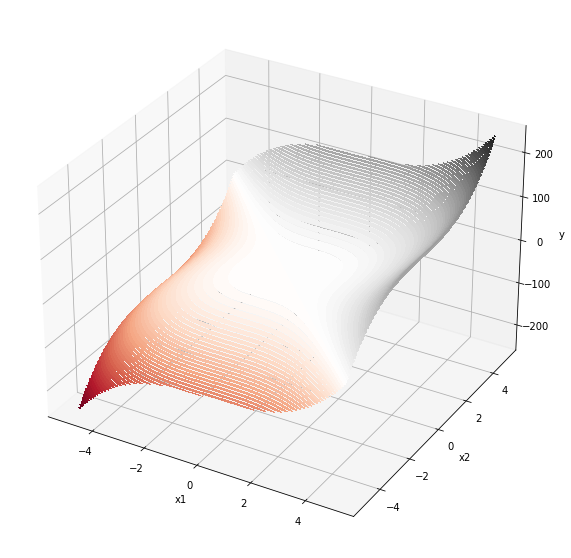

In [60]:
# Visualize ground truth of the function
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contourf(X1_true, X2_true, Y_true, 100, cmap='RdGy')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.savefig(imagePath+'2D_func-2.png',dpi=150)
plt.show()


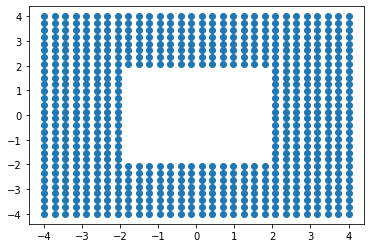

In [61]:
# plot x-y coordinate for training samples (with a gap)
plt.scatter(x[0,:],x[1,:])
plt.show()

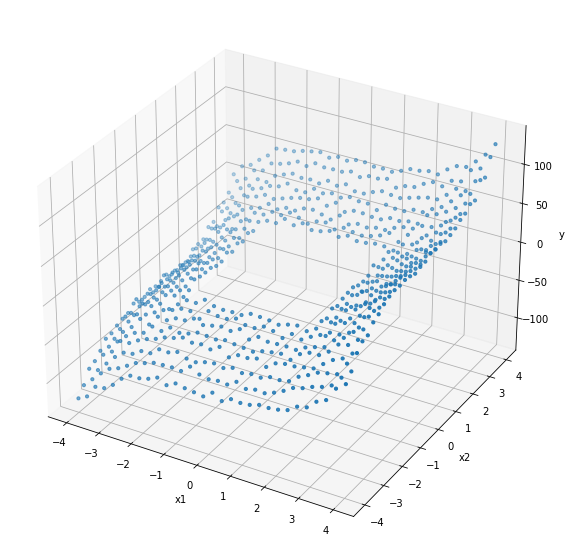

In [62]:
# Visualize training data
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x[0,:],x[1,:],y.flatten(), s = 10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

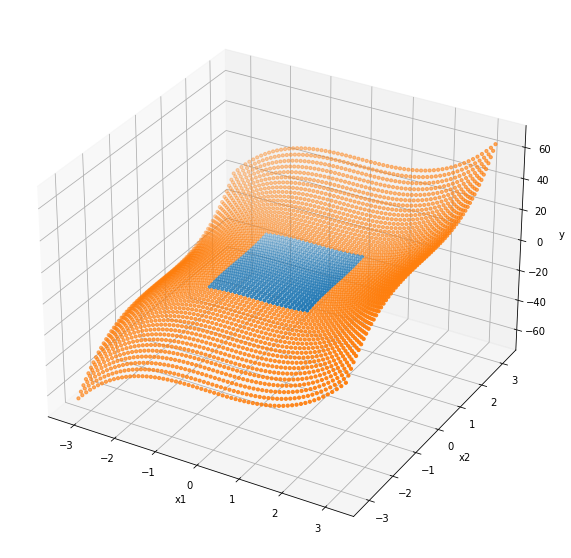

In [63]:
# Visualize test data (gap and non-gap)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x_test_gap[0,:],x_test_gap[1,:],y_test_gap.flatten(), s = 10)
ax.scatter(x_test_non_gap[0,:],x_test_non_gap[1,:],y_test_non_gap.flatten(), s = 10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

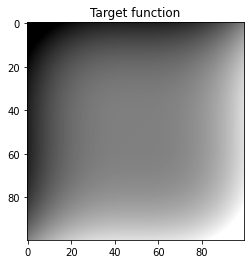

In [64]:
fig = plt.figure()
plt.imshow(Y_true, vmin = np.percentile(Y_true.flatten(),1), vmax = np.percentile(Y_true.flatten(),99), cmap='gray')
plt.title('Target function')
plt.show()

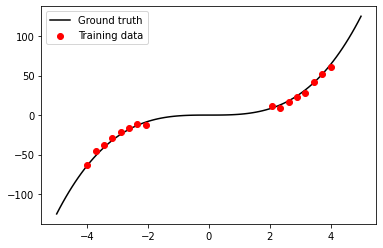

In [65]:
# visualize a slice over the 2-D function
plt.scatter(x_train_slice,y_train_slice,color='r',zorder = 100,label='Training data')
plt.plot(x_test[0,:],y_test_slice,'k',label='Ground truth')
plt.legend()
plt.show()

## Fit with LUNA

In [99]:
# relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [50,50] # using the architecture used in the paper
hidden_layers = len(width)
input_dim = 2
output_dim = 1

architecture = {
    'width': width,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
    'auxiliary_functions': 50,
}

# set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

# instantiate a NN with LUNA
luna = LUNA(architecture, random=random)
print('Number of parameters =',luna.D)

Number of parameters = 5250


### Inspect coSim^2 before fitting

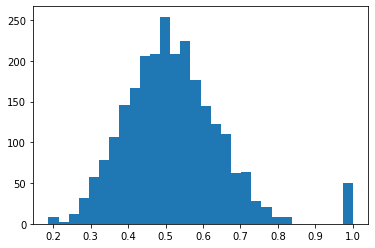

In [100]:
grad_FD = luna._finite_diff_grad(luna.weights, x) # M x dim_in x num of samples
norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints

plt.hist(coSimSqMat.flatten(),bins=30)
plt.show()

### Inspect auxiliary functions before fitting

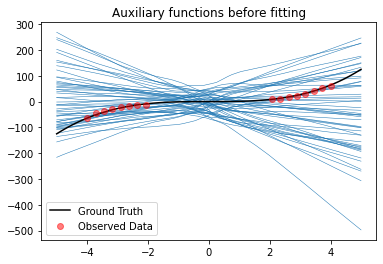

In [101]:
y_pred = luna.forward(luna.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 0.5, alpha=1, zorder = 0,color='tab:blue')
plt.title('Auxiliary functions before fitting')
plt.legend()
plt.show()

### Fit LUNA

In [102]:
### define design choices in gradient descent
params = {
    'step_size':1e-2,
    'max_iteration':2000,
    'random_restarts':1,
    'reg_param':10.,
    'lambda_in':300., # 300
}

# fit LUNA
luna.fit(x, y, params)

Iteration 0 loss 14578.796106120006; gradient mag: 5422.9977877970005
Iteration 100 loss 435.9215445553218; gradient mag: 122.75980660621829
Iteration 200 loss 373.8715483431702; gradient mag: 44.27904278227659
Iteration 300 loss 338.2432291343431; gradient mag: 27.999538713119538
Iteration 400 loss 320.50018639172276; gradient mag: 40.66849182271401
Iteration 500 loss 308.78151683386557; gradient mag: 52.95138186981307
Iteration 600 loss 299.42982039978546; gradient mag: 60.534491046316255
Iteration 700 loss 293.61145576500115; gradient mag: 38.856294926625836
Iteration 800 loss 287.5992068416427; gradient mag: 78.59639491049327
Iteration 900 loss 282.81115479425057; gradient mag: 139.02551358
Iteration 1000 loss 276.7180510064433; gradient mag: 54.51851667446269
Iteration 1100 loss 275.81646829830214; gradient mag: 47.796911729055225
Iteration 1200 loss 274.3580307580855; gradient mag: 51.76818968740835
Iteration 1300 loss 270.5532476899512; gradient mag: 50.68803897843511
Iteration 

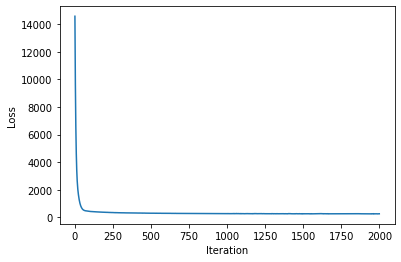

In [103]:
plt.plot(luna.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect coSim^2 after fitting

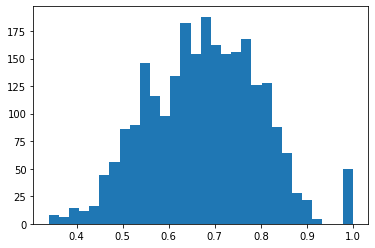

In [104]:
grad_FD = luna._finite_diff_grad(luna.weights, x) # M x dim_in x num of samples
norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints

plt.hist(coSimSqMat.flatten(),bins=30)
plt.show()

### Inspect auxiliary functions after fitting (along a slice)

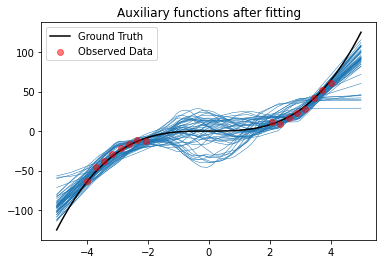

In [105]:
y_pred = luna.forward(luna.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 0.5, alpha=1, zorder = 0,color='tab:blue')
plt.title('Auxiliary functions after fitting')
plt.legend()
plt.show()

### Inspect several auxiliary functions after fitting (on all training points)

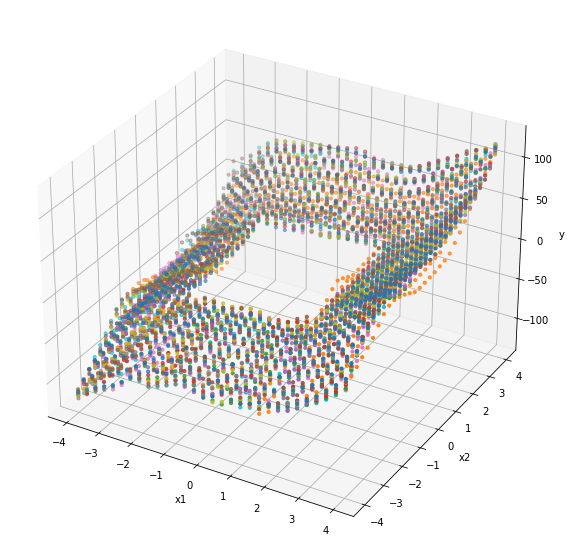

In [106]:
y_pred = luna.forward(luna.weights, x)
y_pred.shape

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

for i in range(10):    
    ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred[i,0,:], s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

### Inspect auxiliary functions after fitting on all test data

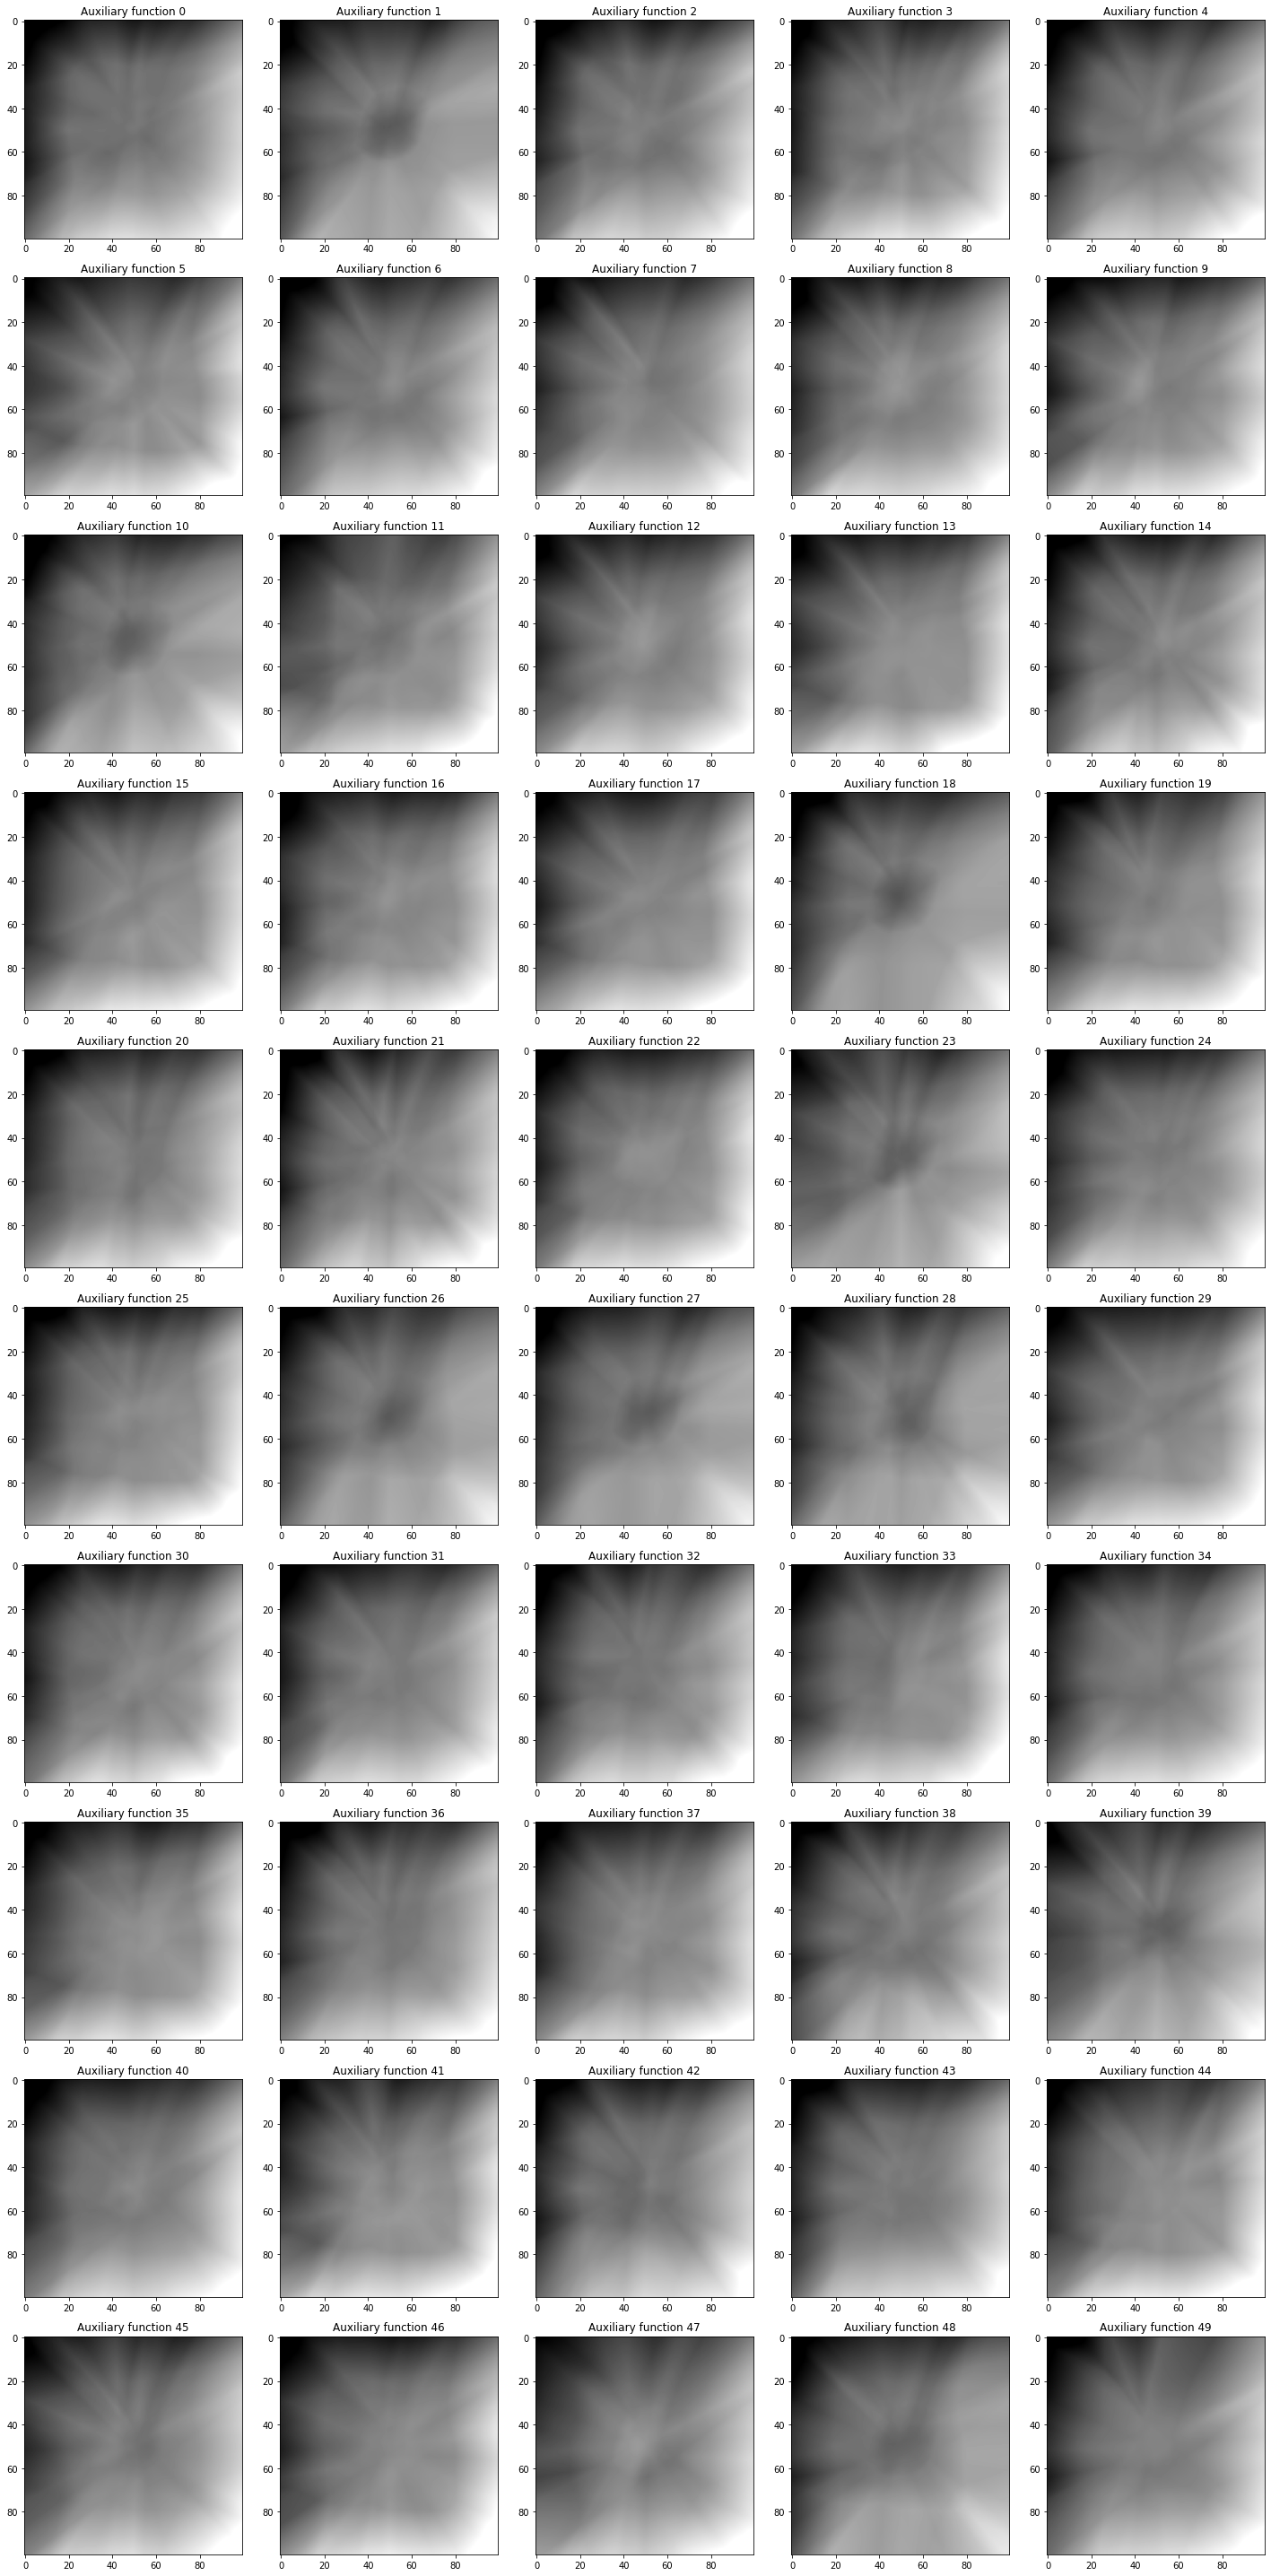

In [107]:
y_pred_test = np.squeeze(luna.forward(luna.weights, x_test_2D))

fig, axes = plt.subplots(int(np.ceil(luna.params['M']/5)), 5, figsize = (20,int(4*np.ceil(luna.params['M']/5))))
for i, ax in enumerate(axes.flat):  
    ax.imshow(y_pred_test[i,:].reshape(Y_true.shape), 
              vmin = np.percentile(y_pred_test.flatten(),1),vmax = np.percentile(y_pred_test.flatten(),99), cmap='gray')
    ax.set_title(f'Auxiliary function {i}')
plt.tight_layout()
plt.show()

### Display prior samples (along a slice)

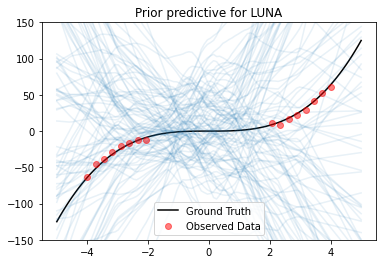

In [121]:
prior_mean = 0
prior_var = 9.
# noise_var = 9.
y_prior = luna.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Prior predictive for LUNA')
plt.legend()
plt.show()

### Display posterior samples

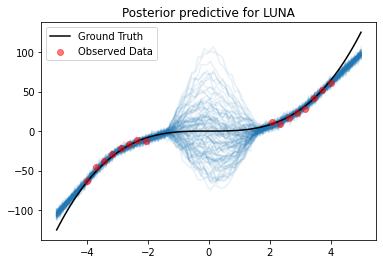

In [122]:
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, zorder = 0,color='tab:blue', alpha=0.1)
plt.title('Posterior predictive for LUNA')
plt.legend()
plt.show()

### Display posterior predictive intervals

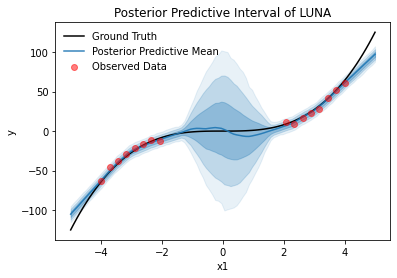

In [123]:
# Calulating percentiles
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing posterior predictive interval of Bayesian polynomial regression
# plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1)
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2)
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3)
plt.legend(frameon=False)
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of LUNA")
plt.show()

### Evaluate log likelihood and epistemic uncertainty

In [124]:
# Compute log likelihood and epistemic uncertainty on training data
y_posterior = luna.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

print('Average log likelihood on training data =', -neg_log_likelihood(y_posterior, y, noise_var))
print('Epistemic uncertainty on training data = ', epistemic_uncertainty(y_posterior))

Average log likelihood on training data = -5.116313145245168
Epistemic uncertainty on training data =  3.0868881016585474


In [125]:
# Compute log ikelihood and epistemic uncertainty on test data (gap vs. non-gap)
y_posterior_gap = luna.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_gap.shape)


y_posterior_non_gap = luna.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_non_gap.shape)


print('Average log likelihood on test data (gap) =', -neg_log_likelihood(y_posterior_gap, y_test_gap, noise_var))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(y_posterior_gap))

print('Average log likelihood on test data (non-gap) =', -neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(y_posterior_non_gap))

Average log likelihood on test data (gap) = -77.56685976822027
Epistemic uncertainty on test data (gap) =  19.253335031917203
Average log likelihood on test data (non-gap) = -4.830562352984632
Epistemic uncertainty on test data (non-gap) =  3.4797591078463754


### Visualize posterior mean and epistemic uncertainty on 2-D test data

In [126]:
y_posterior_test = luna.get_posterior_preds(x_test_2D, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
eps_2D = epistemic_uncertainty(y_posterior_test, take_avg=False)

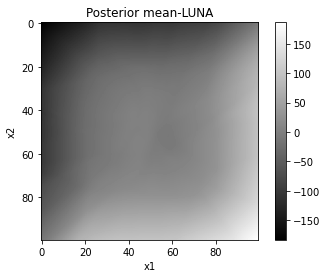

In [127]:
img = plt.imshow(y_posterior_test.mean(axis=0).reshape(Y_true.shape), cmap='gray')
plt.colorbar(img)
plt.title('Posterior mean-LUNA')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

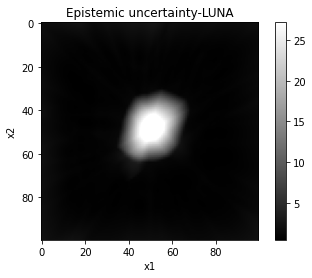

In [128]:
img = plt.imshow(eps_2D.reshape(Y_true.shape), vmax = np.percentile(eps_2D,99), cmap='gray')
plt.colorbar(img)
plt.title('Epistemic uncertainty-LUNA')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Fit with NLM for comparison (with the same hyperparameters)


In [83]:
# instantiate an NLM with same architecture 
nlm = NLM(architecture, random=random)
print('Number of parameters =', nlm.D)

# params = {
#     'step_size':1e-2,
#     'max_iteration':2000,
#     'random_restarts':1,
#     'reg_param':0.
# }

nlm.fit(x,y, params)

Number of parameters = 2751
Iteration 0 loss 5764.811976001852; gradient mag: 16163.733749590192
Iteration 100 loss 76.3262638745615; gradient mag: 72.97991091949761
Iteration 200 loss 31.818904318774624; gradient mag: 18.00950698301191
Iteration 300 loss 24.261121867757762; gradient mag: 24.368673674358245
Iteration 400 loss 19.570824282516288; gradient mag: 13.424510344953267
Iteration 500 loss 17.6464323820212; gradient mag: 16.299418717918073
Iteration 600 loss 16.837458147411063; gradient mag: 23.9656555937542
Iteration 700 loss 16.350773656193702; gradient mag: 15.365713491506225
Iteration 800 loss 16.039273713872838; gradient mag: 18.96992108805068
Iteration 900 loss 15.683100275652404; gradient mag: 23.88182602257817
Iteration 1000 loss 15.39289116943359; gradient mag: 32.38126139173365
Iteration 1100 loss 15.131820116943029; gradient mag: 13.68287122938655
Iteration 1200 loss 14.886869560799038; gradient mag: 18.70993217980772
Iteration 1300 loss 14.654172469540303; gradient m

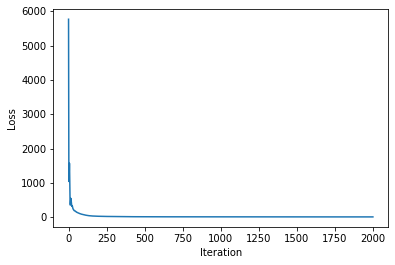

In [84]:
plt.plot(nlm.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect MLE fit

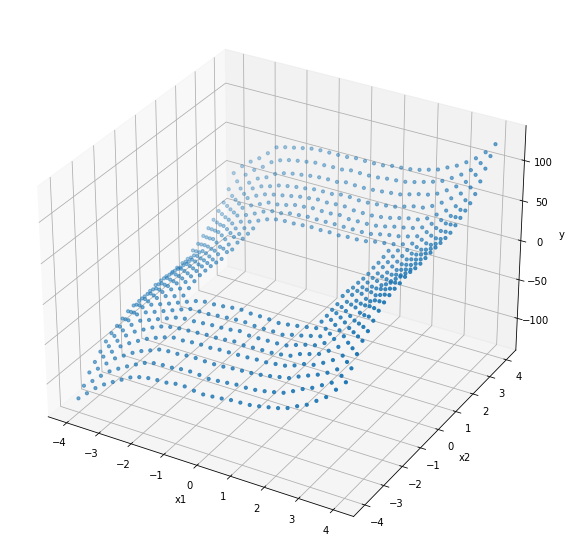

In [85]:
y_pred = nlm.forward(nlm.weights, x)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred.flatten(), s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

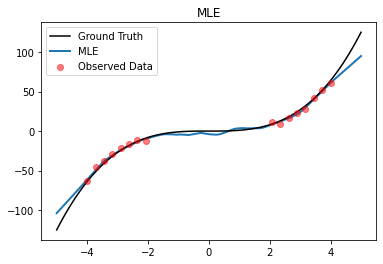

In [86]:
y_pred = nlm.forward(nlm.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 2, alpha=1, zorder = 0,color='tab:blue',label='MLE')
plt.title('MLE')
plt.legend()
plt.show()

### Display prior samples

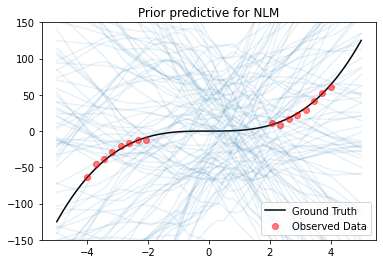

In [129]:
prior_mean = 0
prior_var = 9.
# noise_var = 9.
y_prior = nlm.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Prior predictive for NLM')
plt.legend()
plt.show()

### Display posterior samples

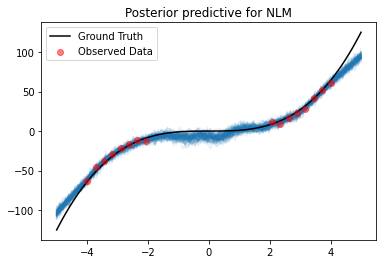

In [130]:
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape) 

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1,zorder=0)
plt.title('Posterior predictive for NLM')
plt.legend()
plt.show()

### Display posterior predictive intervals

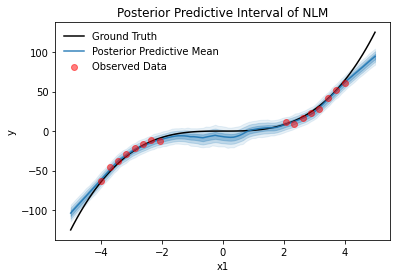

In [132]:
# Calulating percentiles
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing posterior predictive interval of Bayesian polynomial regression
# plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1)
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2)
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3)
plt.legend(frameon=False)
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of NLM")
plt.show()

### Evaluate log likelihood and epistemic uncertainty

In [133]:
# Compute  log likelihood and epistemic uncertainty on training data
y_posterior = nlm.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

print('Average log likelihood on training data =', -neg_log_likelihood(y_posterior, y, noise_var))
print('Epistemic uncertainty on training data = ', epistemic_uncertainty(y_posterior))

Average log likelihood on training data = -4.689678049290201
Epistemic uncertainty on training data =  3.0941440429401155


In [134]:
# Compute log likelihood and epistemic uncertainty on test data (gap vs. non-gap)
y_posterior_gap = nlm.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_gap.shape)


y_posterior_non_gap = nlm.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_non_gap.shape)


print('Average log likelihood on test data (gap) =', -neg_log_likelihood(y_posterior_gap, y_test_gap, noise_var))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(y_posterior_gap))

print('Average log likelihood on test data (non-gap) =', -neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(y_posterior_non_gap))

Average log likelihood on test data (gap) = -9.149339105614033
Epistemic uncertainty on test data (gap) =  3.7999896553005623
Average log likelihood on test data (non-gap) = -4.25818537422636
Epistemic uncertainty on test data (non-gap) =  3.1313312862141225


### Visualize posterior mean and epistemic uncertainty on 2-D test data

In [135]:
y_posterior_test = nlm.get_posterior_preds(x_test_2D, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
eps_2D = epistemic_uncertainty(y_posterior_test, take_avg=False)

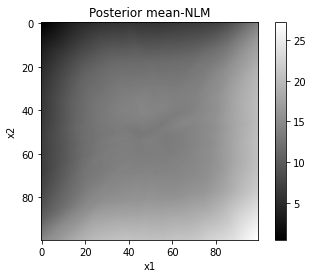

In [136]:
plt.imshow(y_posterior_test.mean(axis=0).reshape(Y_true.shape), cmap='gray')
plt.colorbar(img)
plt.title('Posterior mean-NLM')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

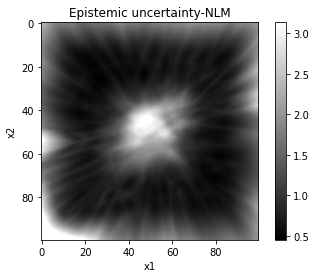

In [137]:
img = plt.imshow(eps_2D.reshape(Y_true.shape), vmax = np.percentile(eps_2D,99), cmap='gray')
plt.colorbar(img)
plt.title('Epistemic uncertainty-NLM')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

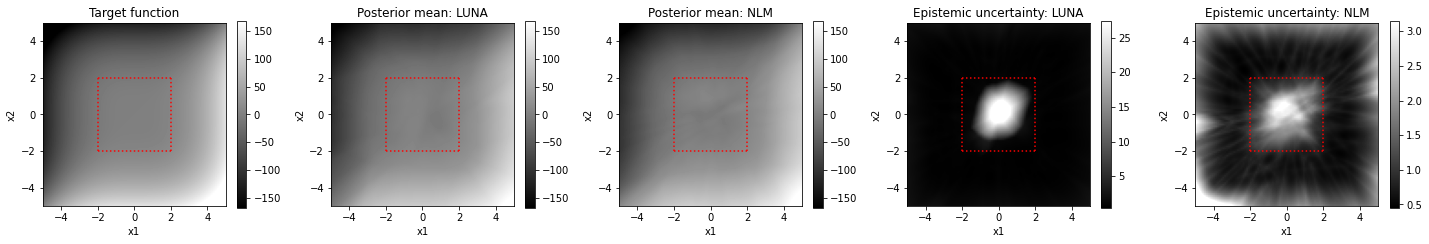

In [138]:
y_posterior_test_luna = luna.get_posterior_preds(x_test_2D, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
eps_2D_luna = epistemic_uncertainty(y_posterior_test_luna, take_avg=False)### Visualize posterior mean and epistemic uncertainty on 2-D test data
y_posterior_test_nlm = nlm.get_posterior_preds(x_test_2D, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
eps_2D_nlm = epistemic_uncertainty(y_posterior_test_nlm, take_avg=False)### Visualize posterior mean and epistemic uncertainty on 2-D test data

fig, axes = plt.subplots(1,5,figsize = (20,4))
img = axes[0].imshow(Y_true, vmin = np.percentile(Y_true.flatten(),1), vmax = np.percentile(Y_true.flatten(),99), cmap='gray', extent=[-5,5,-5,5])
plt.colorbar(img, ax = axes[0], shrink = 0.7)
axes[0].plot([-2,-2],[-2,2],'r:')
axes[0].plot([-2,2],[2,2],'r:')
axes[0].plot([-2,2],[-2,-2],'r:')
axes[0].plot([2,2],[-2,2],'r:')
axes[0].set(title='Target function', xlabel='x1', ylabel='x2')

img = axes[1].imshow(y_posterior_test_luna.mean(axis=0).reshape(Y_true.shape), vmin = np.percentile(Y_true.flatten(),1), vmax = np.percentile(Y_true.flatten(),99),cmap='gray', extent=[-5,5,-5,5])
plt.colorbar(img, ax = axes[1], shrink = 0.7)
axes[1].plot([-2,-2],[-2,2],'r:')
axes[1].plot([-2,2],[2,2],'r:')
axes[1].plot([-2,2],[-2,-2],'r:')
axes[1].plot([2,2],[-2,2],'r:')
axes[1].set(title='Posterior mean: LUNA', xlabel='x1', ylabel='x2')

img = axes[2].imshow(y_posterior_test_nlm.mean(axis=0).reshape(Y_true.shape), vmin = np.percentile(Y_true.flatten(),1), vmax = np.percentile(Y_true.flatten(),99), cmap='gray', extent=[-5,5,-5,5])
plt.colorbar(img, ax = axes[2], shrink = 0.7)
axes[2].plot([-2,-2],[-2,2],'r:')
axes[2].plot([-2,2],[2,2],'r:')
axes[2].plot([-2,2],[-2,-2],'r:')
axes[2].plot([2,2],[-2,2],'r:')
axes[2].set(title='Posterior mean: NLM', xlabel='x1', ylabel='x2')


img = axes[3].imshow(eps_2D_luna.reshape(Y_true.shape), vmax = np.percentile(eps_2D_luna,99), cmap='gray', extent=[-5,5,-5,5])
plt.colorbar(img, ax = axes[3], shrink = 0.7)
axes[3].plot([-2,-2],[-2,2],'r:')
axes[3].plot([-2,2],[2,2],'r:')
axes[3].plot([-2,2],[-2,-2],'r:')
axes[3].plot([2,2],[-2,2],'r:')
axes[3].set(title='Epistemic uncertainty: LUNA', xlabel='x1', ylabel='x2')

img = axes[4].imshow(eps_2D_nlm.reshape(Y_true.shape), vmax = np.percentile(eps_2D_nlm,99), cmap='gray', extent=[-5,5,-5,5])
plt.colorbar(img, ax = axes[4], shrink = 0.7)
axes[4].plot([-2,-2],[-2,2],'r:')
axes[4].plot([-2,2],[2,2],'r:')
axes[4].plot([-2,2],[-2,-2],'r:')
axes[4].plot([2,2],[-2,2],'r:')
axes[4].set(title='Epistemic uncertainty: NLM', xlabel='x1', ylabel='x2')

plt.tight_layout()
# plt.savefig(imagePath+'Comparison_2D_LUNA-2-2.png',dpi=150)
plt.show()

## Fit NLM with no regularization

In [115]:
# instantiate an NLM with same architecture 
nlm0 = NLM(architecture, random=random)
print('Number of parameters =', nlm0.D)

params0 = {
    'step_size':1e-2,
    'max_iteration':2000,
    'random_restarts':1,
    'reg_param':0.
}

nlm0.fit(x,y, params0)

Number of parameters = 2751
Iteration 0 loss 5754.992552666522; gradient mag: 16163.722620776214
Iteration 100 loss 68.06249148784853; gradient mag: 76.4432538916584
Iteration 200 loss 23.407833516646324; gradient mag: 19.750427194035428
Iteration 300 loss 15.975366931748484; gradient mag: 10.670198284604213
Iteration 400 loss 12.416759338942269; gradient mag: 11.380277359919576
Iteration 500 loss 10.314786206629835; gradient mag: 6.524964587422496
Iteration 600 loss 9.302348708669363; gradient mag: 4.7655240238072745
Iteration 700 loss 8.657542851508465; gradient mag: 5.629649506260868
Iteration 800 loss 8.22319129763294; gradient mag: 8.598492593626084
Iteration 900 loss 7.965668375064777; gradient mag: 1.8834684907101935
Iteration 1000 loss 7.762543619618066; gradient mag: 3.358838779149984
Iteration 1100 loss 7.561133275263802; gradient mag: 7.552826530446964
Iteration 1200 loss 7.423359765259823; gradient mag: 27.32205502833537
Iteration 1300 loss 7.298040681313023; gradient mag: 

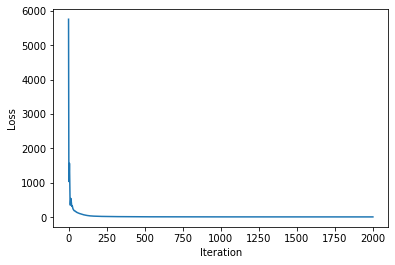

In [117]:
plt.plot(nlm0.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect MLE fit

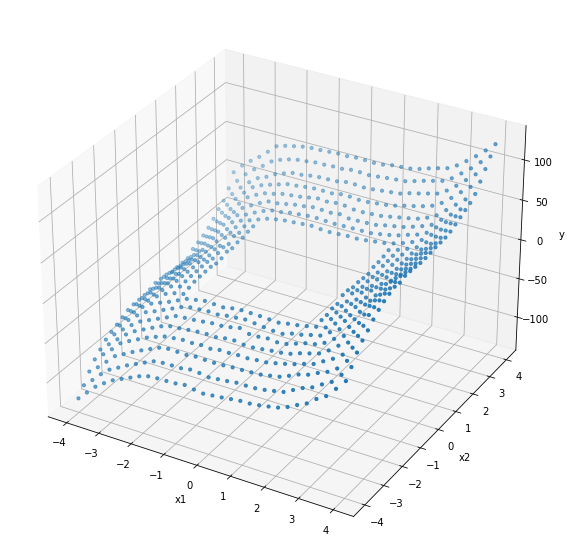

In [118]:
y_pred = nlm0.forward(nlm0.weights, x)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred.flatten(), s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

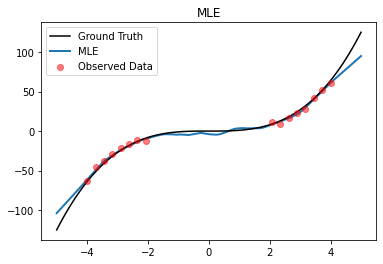

In [119]:
y_pred = nlm0.forward(nlm.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 2, alpha=1, zorder = 0,color='tab:blue',label='MLE')
plt.title('MLE')
plt.legend()
plt.show()

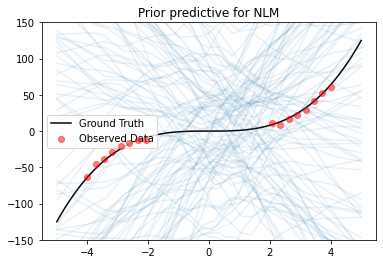

In [120]:
prior_mean = 0
prior_var = 9.
# noise_var = 9.
y_prior = nlm.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Prior predictive for NLM')
plt.legend()
plt.show()

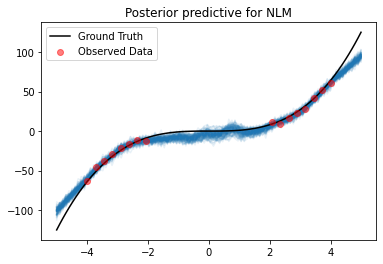

In [140]:
y_posterior = nlm0.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape) 

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1,zorder=0)
plt.title('Posterior predictive for NLM')
plt.legend()
plt.show()

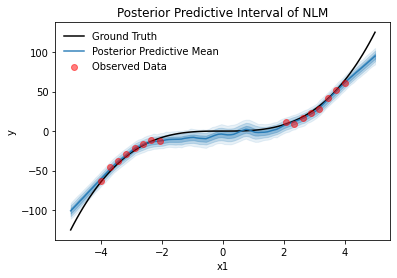

In [141]:
# Calulating percentiles
y_posterior = nlm0.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing posterior predictive interval of Bayesian polynomial regression
# plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1)
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2)
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3)
plt.legend(frameon=False)
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of NLM (reg = 0)")
plt.show()

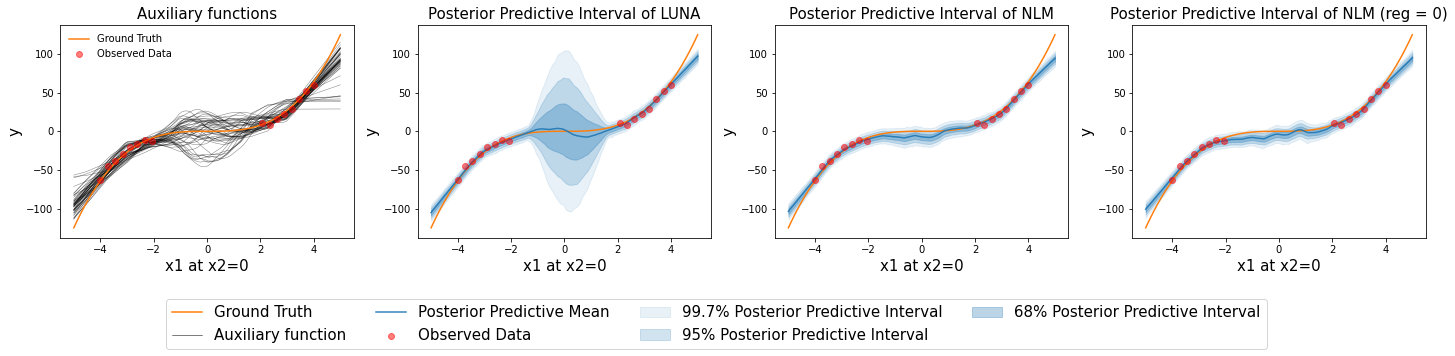

In [159]:
fig, axes = plt.subplots(1,4,figsize = (20,4))

y_pred = luna.forward(luna.weights, x_test)
axes[0].scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
axes[0].plot(x_test[0,:],y_test_slice,'tab:orange', label="Ground Truth")
axes[0].plot(x1_test.T, np.squeeze(y_pred).T,'k',linewidth = 0.5, alpha=0.5, zorder = 0)
axes[0].set_title('Auxiliary functions',fontsize = 15)
axes[0].set_xlabel('x1 at x2=0',fontsize = 15)
axes[0].set_ylabel('y',fontsize = 15)
axes[0].legend(frameon=False)


# Calulating percentiles
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing posterior predictive interval of Bayesian polynomial regression
# plt.figure(figsize=(10,7))
axes[1].scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
axes[1].plot(x_test[0,:],y_test_slice,'tab:orange', label="Ground Truth")
axes[1].plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
axes[1].fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1)
axes[1].fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2)
axes[1].fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3)

axes[1].set_xlabel('x1 at x2=0',fontsize = 15)
axes[1].set_ylabel('y',fontsize = 15)
axes[1].set_title("Posterior Predictive Interval of LUNA",fontsize = 15)


# Calulating percentiles
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
pp_mean = np.mean(y_posterior, axis=0)


# Visualizing posterior predictive interval of Bayesian polynomial regression
# plt.figure(figsize=(10,7))
axes[2].scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
axes[2].plot(x_test[0,:],y_test_slice,'tab:orange', label="Ground Truth")
axes[2].plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
axes[2].fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1)
axes[2].fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2)
axes[2].fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3)
axes[2].set_xlabel('x1 at x2=0',fontsize = 15)
axes[2].set_ylabel('y',fontsize = 15)
axes[2].set_title("Posterior Predictive Interval of NLM",fontsize = 15)

# Calulating percentiles
y_posterior = nlm0.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_upper3 = np.percentile(y_posterior, 99.85, axis=0)
pp_lower3 = np.percentile(y_posterior, 0.15, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing posterior predictive interval of Bayesian polynomial regression
# plt.figure(figsize=(10,7))
axes[3].scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
axes[3].plot(x_test[0,:],y_test_slice,'tab:orange', label="Ground Truth")
axes[3].plot(np.NaN, np.NaN,'k',linewidth = 0.5, label='Auxiliary function')
axes[3].plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
axes[3].fill_between(x_test[0,:], pp_upper3, pp_lower3, color = 'tab:blue', alpha = 0.1, label='99.7% Posterior Predictive Interval')
axes[3].fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
axes[3].fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label='68% Posterior Predictive Interval')
axes[3].set_xlabel('x1 at x2=0',fontsize = 15)
axes[3].set_ylabel('y',fontsize = 15)
axes[3].set_title("Posterior Predictive Interval of NLM (reg = 0)",fontsize = 15)

handles, labels = axes[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4,fontsize = 15,bbox_to_anchor=(0.25, -0.25, 0.5, 0.5))

plt.tight_layout()
# plt.savefig(imagePath+'PPI_2D_LUNA-2-2.png',dpi=150, bbox_inches='tight')
plt.show()



